# Supervised Capstone: Synthetic Sonic Curve Generation
## Background
Well logs can be used to estimate the in-situ petrophysical and geomechanical properties, which is essential for subsurface characterization. Various types of logs exist, and each provides distinct information about subsurface properties. The triple-combo logs, which include gamma ray (GR), resistivity, density, and neutron logs, are considered “easy-to-acquire” conventional well logs that are run in most wells. Other well logs, like nuclear magnetic resonance, dielectric dispersion, elemental spectroscopy, and sometimes sonic logs, are only run in limited number of wells.

Sonic travel-time logs contain critical geomechanical information for subsurface characterization around the wellbore. Often, sonic logs are required to complete the seismic-well tie workflow or geomechanical properties prediction. When sonic logs are absent in a well or an interval, a common practice is to synthesize them based on its neighboring wells with sonic logs. This is referred to as “sonic log synthesis” or “pseudo sonic log generation”.

## Problem Statement
Compressional travel-time (DTC) and shear travel-time (DTS) logs are not acquired in all wells drilled due to financial or operational constraints. Under such circumstances, machine learning can be used to predict DTC and DTS logs to improve subsurface characterization. Our goal is to develop a data-driven model by processing “easy-to-acquire” conventional logs to generate a synthetic compressional travel-time log. This project was initially part of Society of Petrophysicists and Well Log Analysts' (SPWLA) [1st Petrophysical Data-Driven Analytics Contest](https://github.com/pddasig/Machine-Learning-Competition-2020/blob/master/SPWLA%20PDDA%20Contest%20Announcement.pdf) held in March 2020.

## Data Description
The data consists of 30,143 entries obtained from one drilled well. All missing values are marked with -999. Below are the log mnemonics and their descriptions:
*	CAL - caliper (inch)
*	CNC - neutron (decimal)
*	GR - gamma ray (API)
*	HRD - deep resisitivity (ohmm)
*	HRM - medium resistivity (ohmm)
*	PE - photo-electric factor (barn per electron)
*	ZDEN - density (g/cc)
*	DTC - compressional travel-time (ns/ft)

In [0]:
from google.colab import files
import io

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import timeit
from sklearn.model_selection import train_test_split
import sklearn.metrics

In [4]:
uploaded = files.upload()

Saving train.csv to train.csv


In [5]:
df = pd.read_csv(io.BytesIO(uploaded['train.csv']), na_values = -999)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30143 entries, 0 to 30142
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CAL     29633 non-null  float64
 1   CNC     29408 non-null  float64
 2   GR      29889 non-null  float64
 3   HRD     29758 non-null  float64
 4   HRM     29758 non-null  float64
 5   PE      29464 non-null  float64
 6   ZDEN    29462 non-null  float64
 7   DTC     26089 non-null  float64
 8   DTS     25278 non-null  float64
dtypes: float64(9)
memory usage: 2.1 MB


,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
0,NaN,NaN,41.4699,NaN,NaN,NaN,NaN,128.0737,319.0654
1,NaN,NaN,42.5053,NaN,NaN,NaN,NaN,127.8347,318.7825
2,NaN,NaN,43.1548,NaN,NaN,NaN,NaN,127.2307,317.3323
3,NaN,NaN,43.2410,NaN,NaN,NaN,NaN,126.2917,313.6486
4,NaN,NaN,40.3218,NaN,NaN,NaN,NaN,125.3985,307.8903


In [0]:
# number of missing values
df.isnull().sum().sort_values(ascending=False)

DTS     4865
DTC     4054
CNC      735
ZDEN     681
PE       679
CAL      510
HRM      385
HRD      385
GR       254
dtype: int64

In [0]:
# percentage of missing values
round(df.isnull().sum().sort_values(ascending=False).head(20)/len(df)*100, 1)

DTS     16.1
DTC     13.4
CNC      2.4
ZDEN     2.3
PE       2.3
CAL      1.7
HRM      1.3
HRD      1.3
GR       0.8
dtype: float64

# Predict DTC (regression)

In [6]:
df_dtc_ori = df.drop(columns='DTS').dropna(subset=['DTC'])

df_dtc = df_dtc_ori.copy()
df_dtc.isnull().sum().sort_values(ascending=False)

CNC     588
ZDEN    573
PE      572
CAL     399
HRM     385
HRD     385
GR       43
DTC       0
dtype: int64

In [0]:
# percentage of missing values
round(df_dtc.isnull().sum().sort_values(ascending=False).head(20)/len(df_dtc)*100, 1)

CNC     2.3
ZDEN    2.2
PE      2.2
CAL     1.5
HRM     1.5
HRD     1.5
GR      0.2
DTC     0.0
dtype: float64

In [0]:
# print summary statistics
df_dtc.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC
count,26069.000000,25530.000000,26089.000000,25704.000000,25704.000000,25517.000000,25516.000000,26089.000000
mean,8.659230,0.757534,46.876385,2.350240,4.975716,4.994675,2.385778,91.814381
std,1.854136,32.937620,49.768048,3.192496,377.506441,5.016849,0.203600,24.337910
min,5.930400,-0.102800,1.038900,0.123600,0.134100,-0.023200,-1.923800,49.970500
25%,7.020900,0.125100,16.252700,0.679800,0.676575,0.052000,2.222175,71.357000
50%,8.625000,0.210800,37.082200,1.442450,1.448050,4.859600,2.428800,85.237600
75%,9.076200,0.369700,58.145400,3.102375,3.242075,8.053700,2.553900,112.112600
max,21.064200,3490.158200,1470.253400,206.718200,60467.761700,28.106400,3.259700,155.980300


Observation: The maximum HRM and CNC values seem erraneous (both HRD and HRM measure resistivity, however HRM_max is too significantly large compared to HRD_max). CNC is a measure of porosity (in decimals), so having a maximum value of 3490 does not make sense. We will inspect and visualize these variables.

In [0]:
df_dtc.sort_values(by='HRM', ascending=False)

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC
27876,8.6250,0.3950,254.2373,206.7182,60467.7617,0.0309,2.5092,99.4185
18916,6.0445,0.0202,12.5908,75.3066,2268.3940,5.9747,2.7332,51.8416
18915,6.0521,0.0316,12.8760,95.7586,914.1912,5.3638,2.7254,50.2787
19938,8.5000,0.2643,39.9916,1.5734,637.8783,4.7394,2.1846,90.9413
18912,6.0144,0.0601,12.8983,89.4792,460.6274,4.9633,2.5402,53.4773
...,...,...,...,...,...,...,...,...
380,9.1165,NaN,33.2890,NaN,NaN,NaN,NaN,136.3456
381,9.3658,NaN,32.6672,NaN,NaN,NaN,NaN,140.4026
382,9.4039,NaN,32.1370,NaN,NaN,NaN,NaN,143.3167
383,9.3717,NaN,30.2842,NaN,NaN,NaN,NaN,144.8578


We can see 2 erraneous values of HRM (2268 and 60468).

In [0]:
df_dtc.sort_values(by='CNC', ascending=False).head(30)

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC
5109,9.4498,3490.1582,42.9026,0.6102,0.5907,9.0183,2.2400,121.4253
8145,9.1380,2819.0356,6.7569,2.9736,2.7666,12.3428,2.4625,66.5344
5110,9.4648,1791.5337,45.3534,0.6157,0.6002,8.9302,2.2304,121.4850
5108,9.4488,1244.3617,42.6629,0.6092,0.5895,9.1958,2.2602,120.9972
8146,9.1150,1238.9564,7.5531,3.0503,2.8654,12.0993,2.4662,66.4550
8144,9.1619,1029.5863,5.7728,2.9062,2.6915,12.1558,2.4700,66.6269
13252,8.5512,365.8850,36.8993,0.3821,0.4650,5.9517,2.1316,95.7638
13253,8.5504,237.5623,37.1879,0.3650,0.4273,5.4500,2.1387,95.7608
5111,9.4425,154.9236,46.3120,0.6240,0.6132,7.9891,2.2299,121.3298
8887,NaN,56.3138,10.7188,2.4414,2.4329,6.5469,2.5118,70.1010


CNC has more erraneous values. We will visualize a boxplot of the data.

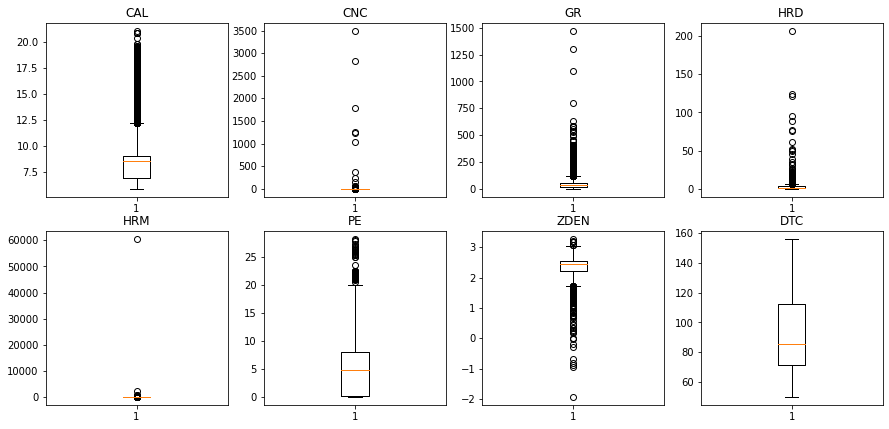

In [0]:
# plot boxplot
fig = plt.figure(figsize = (15,30))
dtc_cols = df_dtc.columns.tolist()
for i, col in enumerate(dtc_cols):
  plt.subplot(len(dtc_cols), 4, i+1)
  plt.boxplot(df_dtc[col].dropna())
  plt.title(col)

plt.show()

Observation: The features are highly skewed. The target variable DTC looks the most normal.

In [0]:
# replace erraneous values with nan
df_dtc['HRM'] = np.where(df_dtc['HRM'] > 1000, np.nan, df_dtc['HRM'])
df_dtc['CNC'] = np.where(df_dtc['CNC'] > 3, np.nan, df_dtc['CNC'])

In [0]:
# reinspect HRM & CNC data
df_dtc.sort_values(by='HRM', ascending=False).head()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC
18915,6.0521,0.0316,12.8760,95.7586,914.1912,5.3638,2.7254,50.2787
19938,8.5000,0.2643,39.9916,1.5734,637.8783,4.7394,2.1846,90.9413
18912,6.0144,0.0601,12.8983,89.4792,460.6274,4.9633,2.5402,53.4773
390,11.9581,NaN,29.5494,5.3812,250.7087,NaN,NaN,126.3617
19941,8.5469,0.2606,42.4938,1.8260,213.4901,0.0506,2.1926,91.6687


In [0]:
df_dtc.sort_values(by='CNC', ascending=False).head(25)

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC
7947,8.9998,2.924500,7.6825,4.2856,4.6941,10.7984,2.5161,62.1332
7948,8.9825,2.827200,7.2754,4.2516,4.6796,10.5330,2.5220,61.9376
6326,9.0328,2.753200,82.0429,0.8047,0.7987,3.7696,2.3105,129.7086
7946,8.9977,2.717600,8.8411,4.3185,4.7080,11.2213,2.5144,62.8514
950,10.9281,2.563600,64.8552,1.1636,1.1281,4.8817,2.1304,126.4869
3194,12.5499,2.503800,62.0955,0.5978,0.5909,10.6868,2.1882,137.8018
4923,10.5180,2.454200,51.7642,0.4956,0.4887,7.3414,2.2046,133.0598
4139,12.4235,2.344400,34.1868,0.5238,0.5331,17.4975,2.0894,129.8057
3360,12.1914,2.314000,48.7514,0.5390,0.5265,10.0345,2.1661,132.3498
1341,10.3776,2.248600,60.6887,1.0875,1.0715,4.6858,2.1293,126.8018


In [0]:
# interpolate missing values
for i in df_dtc.columns:
  df_dtc[i] = df_dtc[i].fillna(df_dtc[i].interpolate())

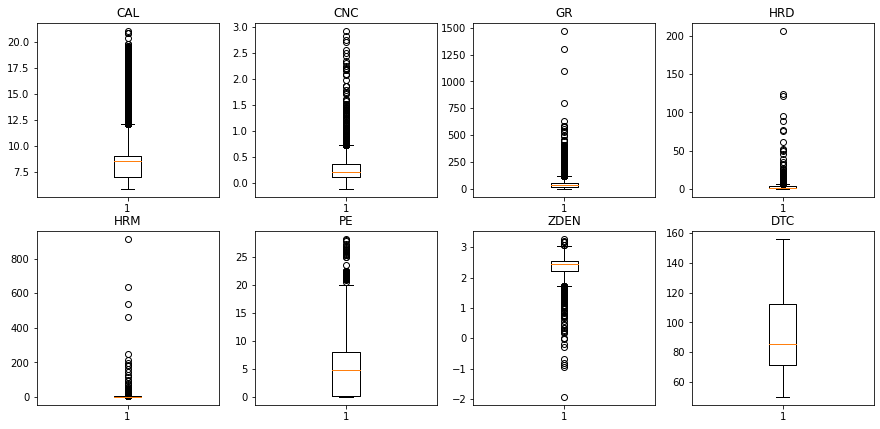

In [0]:
# replot boxplot
fig = plt.figure(figsize = (15,30))
dtc_cols = df_dtc.columns.tolist()
for i, col in enumerate(dtc_cols):
  plt.subplot(len(dtc_cols), 4, i+1)
  plt.boxplot(df_dtc[col].dropna())
  plt.title(col)

plt.show()

Observation: after handling erraneous values, the data still contain a lot of outliers. However, most of these outliers are continuous rather than dispersed, which suggests they may be actual values (i.e. not due to errors). We will leave these as is.

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


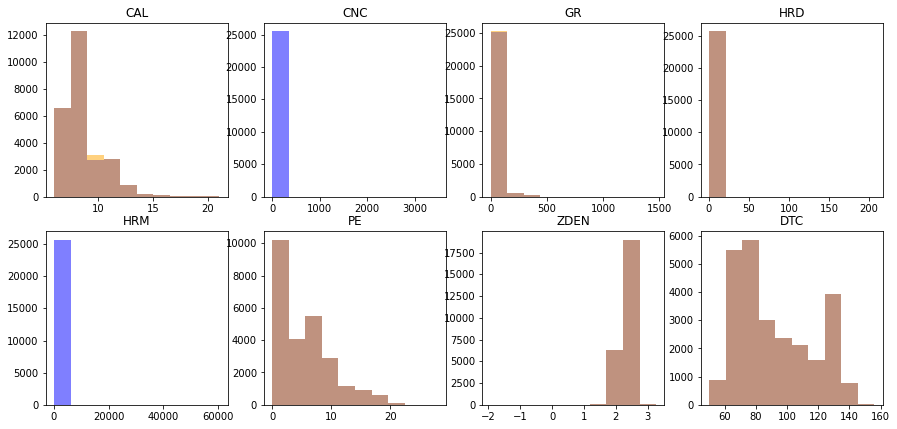

In [11]:
# plot histogram with and without filling in missing values
dtc_cols = df_dtc.columns.tolist()

fig = plt.figure(figsize = (15,30))
for i, col in enumerate(dtc_cols):
  plt.subplot(len(dtc_cols), 4, i+1)
  plt.hist(df_dtc_ori[col], alpha = 0.5, color = 'blue')
  plt.hist(df_dtc[col], alpha = 0.5, color = 'orange')
  plt.title(col)

plt.show()

The fillna method seems reasonable. With the exception of CNC and HRM, the additional filled-in missing values does not seem to alter the original distribution of the variables significantly.

In [0]:
df_dtc.isnull().sum().sort_values(ascending=False)

ZDEN    573
PE      572
CNC     559
HRM     385
HRD     385
CAL      20
DTC       0
GR        0
dtype: int64

In [0]:
# percentage of missing values
round(df_dtc.isnull().sum().sort_values(ascending=False).head(20)/len(df_dtc)*100, 1)

ZDEN    2.2
PE      2.2
CNC     2.1
HRM     1.5
HRD     1.5
CAL     0.1
DTC     0.0
GR      0.0
dtype: float64

After interpolating, we notice there are still a small percentage of missing values. This is because the interpolation was only done one-way forward, not backward. Since the tools for the different measurements are located at different depths, there will always be missing values located at the beginning of drilling.

In [0]:
df_dtc.head()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC
0,NaN,NaN,41.4699,NaN,NaN,NaN,NaN,128.0737
1,NaN,NaN,42.5053,NaN,NaN,NaN,NaN,127.8347
2,NaN,NaN,43.1548,NaN,NaN,NaN,NaN,127.2307
3,NaN,NaN,43.2410,NaN,NaN,NaN,NaN,126.2917
4,NaN,NaN,40.3218,NaN,NaN,NaN,NaN,125.3985


Next, we will inspect the correlation between the variables using a pairplot.

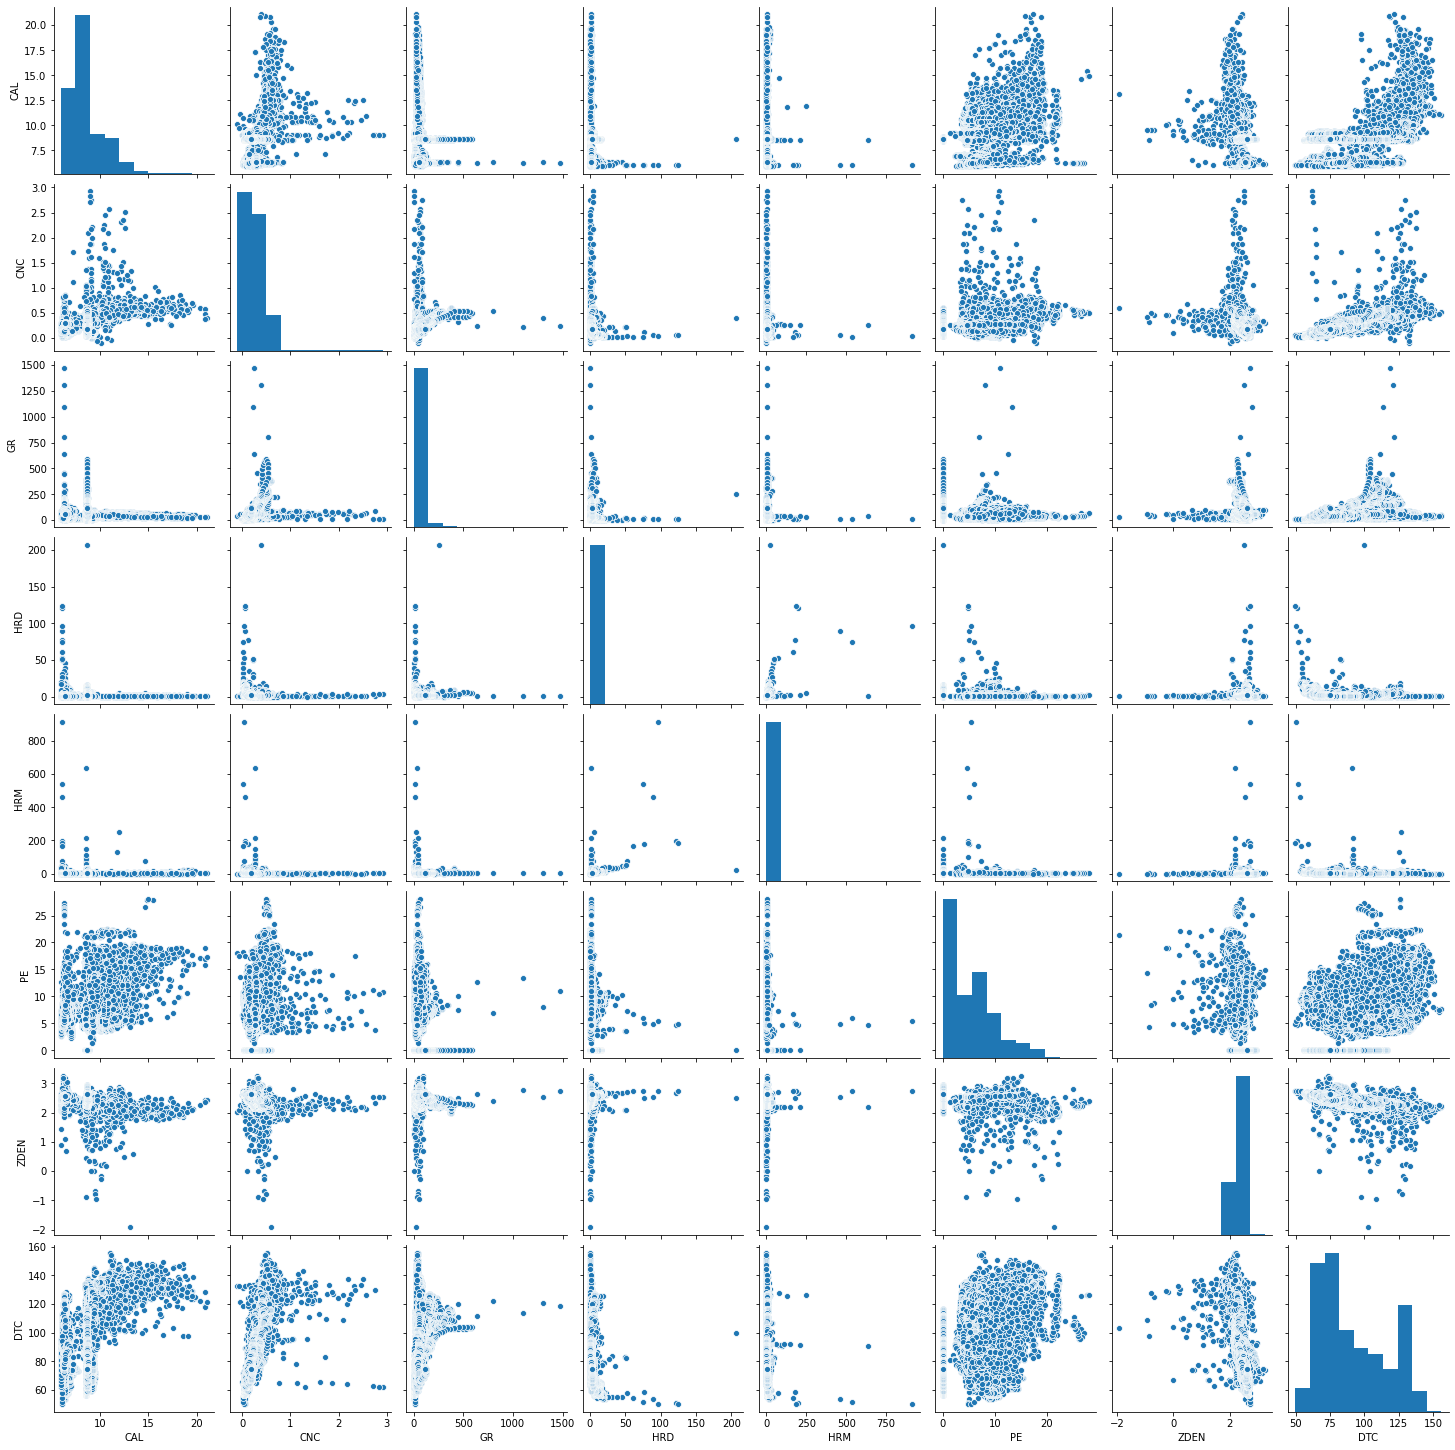

In [0]:
sns.pairplot(df_dtc)

From most of the plots, it seems there is a trend distinguishing high values from low values between the different variables, resulting in the L-shaped curves. Looking at the relationship between the features (CAL, CNC, GR, HRD, HRM, PE, ZDEN) and target variable (DTC), we notice the following trend:
* CAL and CNC have a positive relationship with DTC
* ZDEN has a (somewhat) negative relationship with DTC

We will inspect Pearson's correlation coefficient to quantify this trend:

In [0]:
df_dtc.corr()
# df_dtc.corr()[0.3<abs(df_dtc.corr())]

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC
CAL,1.000000,0.556747,0.006456,-0.185801,-0.052554,0.182924,-0.382524,0.578573
CNC,0.556747,1.000000,0.386366,-0.364896,-0.138992,0.452872,-0.633486,0.867041
GR,0.006456,0.386366,1.000000,-0.062764,-0.024466,-0.033199,-0.160522,0.355096
HRD,-0.185801,-0.364896,-0.062764,1.000000,0.510596,-0.166255,0.421463,-0.426659
HRM,-0.052554,-0.138992,-0.024466,0.510596,1.000000,-0.079769,0.152845,-0.156046
PE,0.182924,0.452872,-0.033199,-0.166255,-0.079769,1.000000,-0.357281,0.477204
ZDEN,-0.382524,-0.633486,-0.160522,0.421463,0.152845,-0.357281,1.000000,-0.731694
DTC,0.578573,0.867041,0.355096,-0.426659,-0.156046,0.477204,-0.731694,1.000000


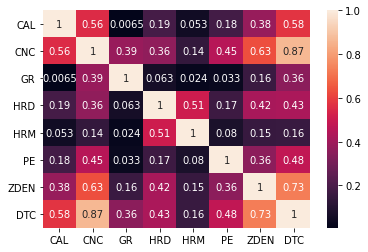

In [14]:
sns.heatmap(abs(df_dtc.corr()), annot=True)

The results show the following:
* ZDEN & CNC are strongly correlated with DTC (0.7<|r|<1).
* CAL, GR, HRD, and PE are moderately correlated with DTC (0.3<|r|<0.7).
* HRM is weakly correlated with DTC (|r|<<0.3).
* None of the features are highly correlated with one another. 

## Baseline Model

In [0]:
# We will use RMSE & R-squared to evaluate and compare our models
from scipy.stats import linregress

def rmse(predictions, actual):
    return -np.sqrt(((predictions - actual) ** 2).mean())

def r2(predictions, actual):
    slope, intercept, r_value, p_value, std_err = linregress(predictions, actual)
    return r_value**2

In [0]:
df_dtc = df_dtc.dropna()

X = df_dtc.drop(columns = 'DTC')
Y = df_dtc['DTC']

Baseline (mean) RMSE: -23.95
Baseline (mean) R2: 0.00


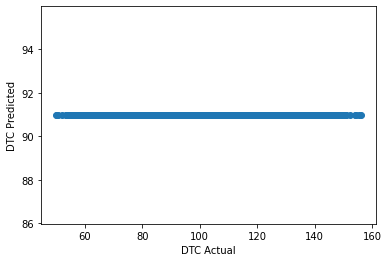

In [0]:
# assume the model predicts the mean of the target variable
y_mean = np.repeat(np.mean(Y), len(Y))

score_baseline_mean = rmse(y_mean, Y)
score_baseline_mean_r2 = r2(y_mean, Y)

plt.scatter(Y, y_mean)
plt.xlabel('DTC Actual')
plt.ylabel('DTC Predicted')

print("Baseline (mean) RMSE: %0.2f" % score_baseline_mean)
print("Baseline (mean) R2: %0.2f" % score_baseline_mean_r2)

Baseline (median) RMSE: -25.06
Baseline (median) R2: 0.00


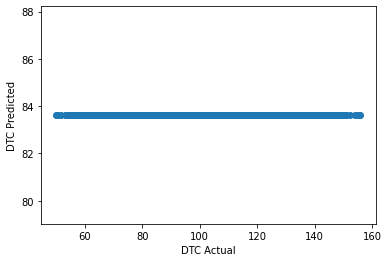

In [0]:
# assume the model predicts the median of the target variable
y_median = np.repeat(np.median(Y), len(Y))

score_baseline_median = rmse(y_median, Y)
score_baseline_median_r2 = r2(y_median, Y)

plt.scatter(Y, y_median)
plt.xlabel('DTC Actual')
plt.ylabel('DTC Predicted')

print("Baseline (median) RMSE: %0.2f" % np.mean(score_baseline_median))
print("Baseline (median) R2: %0.2f" % score_baseline_median_r2)

# Feature Augmentation
The models will be evaluated using different combinations of the following:
* Original features, X
* Augmented features, X_lr
* Target variable, Y
* Log of Y, Y_log

Feature augmentation will be done by the following:
* log-transforming resistivity values, HRD & HRM (standard industry practice)
* shifting the values one point up, one point down, and calculating the gradient between datapoints (as per [Bestagini et al](http://home.deib.polimi.it/bestagini/_Papers/2017_SEG_facies.pdf), 2017)
* calculating Archie's relationship (as per [Chen and Zeng](https://arxiv.org/pdf/1808.09856.pdf), 2018)

In [0]:
# the following funcation is used to create augmented features after Bestagini et al, 2017
# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]

    # column names
    X_col = X.columns.to_list()

    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))

    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row

    cols = ['{}_shift1down'.format(i) for i in X_col] + X_col + ['{}_shift1up'.format(i) for i in X_col]

    return pd.DataFrame(X_aug, columns = cols)

# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return pd.DataFrame(X_grad, columns = ['{}_gradient'.format(i) for i in X.columns])

# Feature augmentation function
def augment_features(X, depth, N_neig=1): # well, 
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))

    X_aug_win = augment_features_window(X, N_neig)
    X_aug_grad = augment_features_gradient(X, depth)
    # X_aug = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    X_aug = pd.concat((X_aug_win, X_aug_grad), axis=1)
    
    return X_aug

In [0]:
from numpy import inf
from sklearn.preprocessing import RobustScaler

# --------------------------------- #
# ------ original features X ------ #
X = df_dtc.drop(columns = 'DTC')

# --------------------------------- #
# ---- augmented features X_lr ---- #
X_lr = X.copy()

# log-transform HRD & HRM
X_lr[['HRD', 'HRM']] = np.log10(X_lr[['HRD', 'HRM']])

# incorporating Archie's relationship (after Chen and Zeng, 2018)
X_lr['logHRD_logCNC'] = np.log10(X_lr['HRD']) / np.log10(X_lr['CNC'])

# replace inf with nan & interpolate missing values
X_lr['logHRD_logCNC'][X_lr['logHRD_logCNC'] == inf] = np.nan

for i in X_lr.columns:
  X_lr[i] = X_lr[i].fillna(X_lr[i].interpolate())

# use Bestagini's feature augmentation (2017)
depth = X_lr.reset_index()['index']
X_lr = augment_features(X_lr, depth, N_neig=1)
X_lr = pd.DataFrame(X_lr)

# --------------------------------- #
# ------- original target Y ------- #
Y = df_dtc['DTC']

# --------------------------------- #
# ------- log target Y_log -------- #
Y_log = np.log10(df_dtc['DTC'])

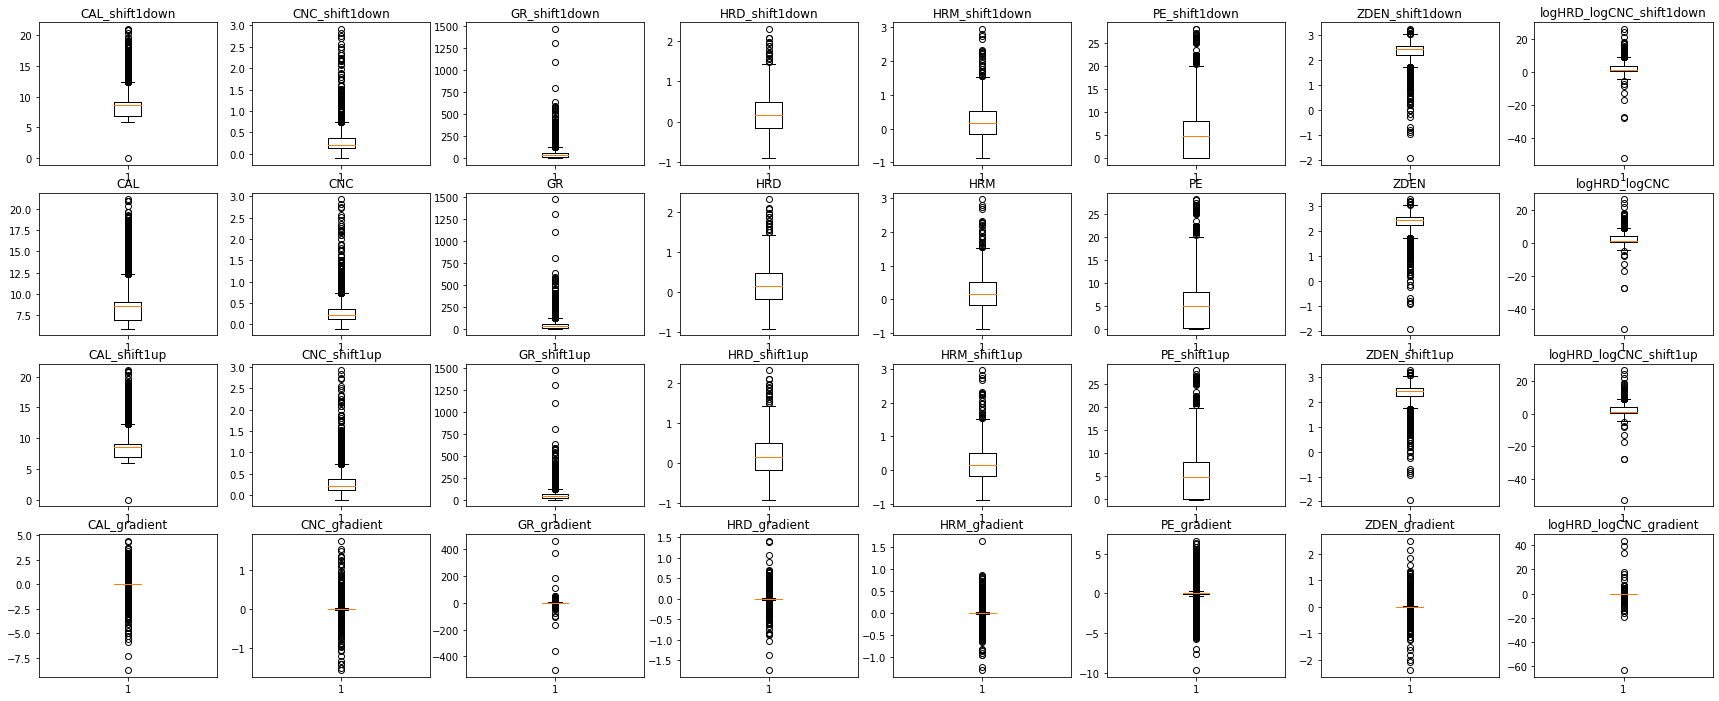

In [0]:
# X_lr boxplot
fig = plt.figure(figsize = (30,100))
X_lr_cols = X_lr.columns.tolist()

for i, col in enumerate(X_lr_cols):
  plt.subplot(len(X_lr_cols), 8, i+1)
  plt.boxplot(X_lr[col].dropna())
  plt.title(col)

plt.show()

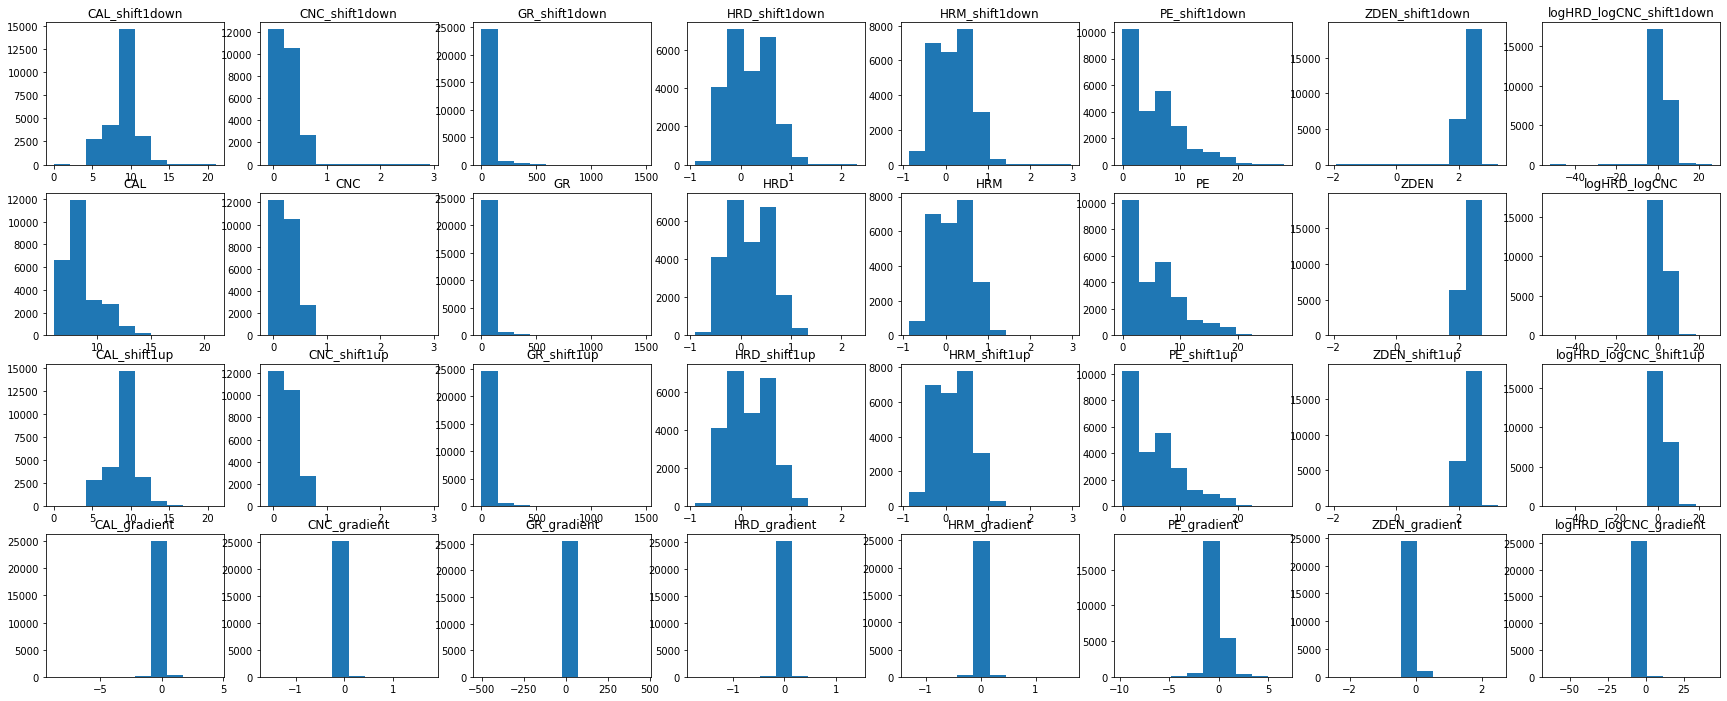

In [0]:
# X_lr histogram
fig = plt.figure(figsize = (30,100))
for i, col in enumerate(X_lr_cols):
  plt.subplot(len(X_lr_cols), 8, i+1)
  plt.hist(X_lr[col])
  plt.title(col)

plt.show()

In [0]:
dtc = df_dtc['DTC']
X_lr_corr = pd.concat([X_lr, dtc], axis=1)

X_lr_corr.corr()

,CAL_shift1down,CNC_shift1down,GR_shift1down,HRD_shift1down,HRM_shift1down,PE_shift1down,ZDEN_shift1down,logHRD_logCNC_shift1down,CAL,CNC,GR,HRD,HRM,PE,ZDEN,logHRD_logCNC,CAL_shift1up,CNC_shift1up,GR_shift1up,HRD_shift1up,HRM_shift1up,PE_shift1up,ZDEN_shift1up,logHRD_logCNC_shift1up,CAL_gradient,CNC_gradient,GR_gradient,HRD_gradient,HRM_gradient,PE_gradient,ZDEN_gradient,logHRD_logCNC_gradient,DTC
CAL_shift1down,1.000000,0.556409,0.003876,-0.226346,-0.207233,0.182474,-0.379121,0.625524,0.988074,0.553948,0.003910,-0.226603,-0.207502,0.178397,-0.379087,6.251807e-01,0.973748,0.552614,0.004088,-0.226721,-0.207588,0.176115,-0.376122,0.624946,-0.097181,-0.004256,0.001378,-0.000857,-0.000551,-1.754081e-02,0.005604,-0.000962,0.582526
CNC_shift1down,0.556409,1.000000,0.386457,-0.509830,-0.512989,0.452853,-0.631095,0.714310,0.557942,0.948424,0.384407,-0.509521,-0.512753,0.450376,-0.633507,7.152071e-01,0.559106,0.873384,0.382841,-0.509074,-0.512264,0.448868,-0.628937,0.717759,0.007939,-0.234125,-0.012400,0.003270,0.003306,-1.151737e-02,0.007317,0.010339,0.570360
GR_shift1down,0.003876,0.386457,1.000000,0.003354,0.009235,-0.033158,-0.159736,0.088529,0.003453,0.388124,0.991701,0.004534,0.009872,-0.034105,-0.161579,8.855574e-02,0.003251,0.388685,0.972743,0.006264,0.010808,-0.034497,-0.162313,0.088175,0.000283,0.002090,-0.146148,0.014163,0.007147,-2.084541e-03,-0.001312,-0.001372,-0.114626
HRD_shift1down,-0.226346,-0.509830,0.003354,1.000000,0.982861,-0.286342,0.686866,-0.594767,-0.226550,-0.509701,0.003419,0.992178,0.975424,-0.286899,0.687761,-5.933312e-01,-0.226580,-0.508987,0.004200,0.979000,0.961595,-0.287750,0.683859,-0.590863,0.000307,0.002214,0.006449,-0.105254,-0.101231,-5.713883e-03,-0.004976,0.009794,-0.330217
HRM_shift1down,-0.207233,-0.512989,0.009235,0.982861,1.000000,-0.323100,0.681902,-0.598827,-0.207443,-0.512644,0.009366,0.975484,0.990690,-0.323897,0.682556,-5.973841e-01,-0.207495,-0.511584,0.009943,0.961883,0.974123,-0.324902,0.678397,-0.594639,0.000148,0.003296,0.004840,-0.108652,-0.121333,-6.713219e-03,-0.005780,0.010905,-0.352384
PE_shift1down,0.182474,0.452853,-0.033158,-0.286342,-0.323100,1.000000,-0.355833,0.419360,0.185166,0.454096,-0.032533,-0.286197,-0.322809,0.989660,-0.360497,4.194095e-01,0.187574,0.453845,-0.032131,-0.286485,-0.322935,0.971769,-0.361686,0.419357,0.015610,-0.000912,0.002400,-0.002601,-0.001196,-1.332689e-01,-0.007462,-0.000220,0.597821
ZDEN_shift1down,-0.379121,-0.631095,-0.159736,0.686866,0.681902,-0.355833,1.000000,-0.615579,-0.386134,-0.629442,-0.159166,0.685768,0.680889,-0.355759,0.934244,-6.157964e-01,-0.386618,-0.625480,-0.158725,0.683589,0.678640,-0.355154,0.834982,-0.614924,-0.002185,0.012353,0.004172,-0.016964,-0.016061,4.794073e-03,-0.271036,0.003390,-0.426398
logHRD_logCNC_shift1down,0.625524,0.714310,0.088529,-0.594767,-0.598827,0.419360,-0.615579,1.000000,0.625870,0.716973,0.088083,-0.593472,-0.597438,0.419070,-0.617281,9.686491e-01,0.626222,0.718453,0.087855,-0.591075,-0.594752,0.419236,-0.615109,0.961409,0.002177,0.004716,-0.002187,0.018824,0.019376,7.572809e-04,0.000398,-0.028781,0.725509
CAL,0.988074,0.557942,0.003453,-0.226550,-0.207443,0.185166,-0.386134,0.625870,1.000000,0.556409,0.003702,-0.226528,-0.207408,0.182368,-0.382524,6.256503e-01,0.988975,0.554476,0.003948,-0.226650,-0.207545,0.179415,-0.378293,0.625418,-0.074385,-0.006127,0.001902,-0.000893,-0.000922,-2.244549e-02,0.009144,-0.000954,0.582486
CNC,0.553948,0.948424,0.388124,-0.509701,-0.512644,0.454096,-0.629442,0.716973,0.556409,1.000000,0.386381,-0.509882,-0.513041,0.452831,-0.633486,7.143036e-01,0.558133,0.948569,0.384444,-0.509514,-0.512747,0.450848,-0.631626,0.715228,0.011807,-0.160429,-0.015293,0.002645,0.001882,-1.500179e-02,-0.000320,0.003832,0.570684


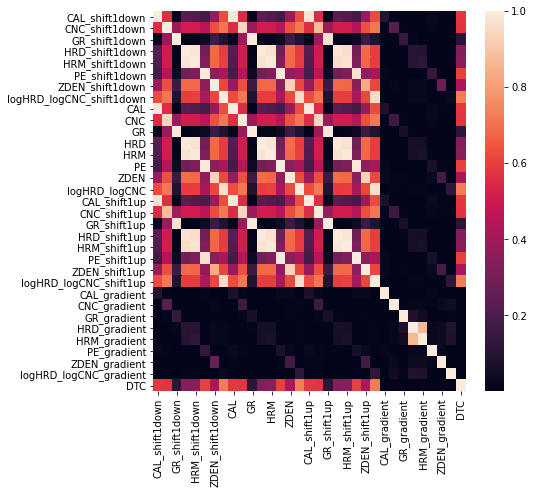

In [0]:
plt.figure(figsize=(7,7))
sns.heatmap(abs(X_lr_corr.corr()))

In [0]:
X_lr_corr.corr()[abs(X_lr_corr.corr())>0.9]

,CAL_shift1down,CNC_shift1down,GR_shift1down,HRD_shift1down,HRM_shift1down,PE_shift1down,ZDEN_shift1down,logHRD_logCNC_shift1down,CAL,CNC,GR,HRD,HRM,PE,ZDEN,logHRD_logCNC,CAL_shift1up,CNC_shift1up,GR_shift1up,HRD_shift1up,HRM_shift1up,PE_shift1up,ZDEN_shift1up,logHRD_logCNC_shift1up,CAL_gradient,CNC_gradient,GR_gradient,HRD_gradient,HRM_gradient,PE_gradient,ZDEN_gradient,logHRD_logCNC_gradient,DTC
CAL_shift1down,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.988074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.973748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CNC_shift1down,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.948424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GR_shift1down,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.991701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.972743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HRD_shift1down,NaN,NaN,NaN,1.000000,0.982861,NaN,NaN,NaN,NaN,NaN,NaN,0.992178,0.975424,NaN,NaN,NaN,NaN,NaN,NaN,0.979000,0.961595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HRM_shift1down,NaN,NaN,NaN,0.982861,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.975484,0.990690,NaN,NaN,NaN,NaN,NaN,NaN,0.961883,0.974123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PE_shift1down,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.989660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.971769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZDEN_shift1down,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.934244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
logHRD_logCNC_shift1down,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.968649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.961409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CAL,0.988074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.988975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CNC,NaN,0.948424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.948569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
sns.pairplot(X_lr_corr)

Output hidden; open in https://colab.research.google.com to view.

From the pairplot and Pearson's correlation coefficients above, we see some multicollinearity between the feature variables. This is in fact expected since shifting the values one point up and one point down does not alter the distribution of the variable significantly, hence leading to a high multicollinearity between the shifted and original values of the features.

This is important to keep in mind when evaluating the assumptions of linear models.

# Model Building
The following models will be built:

1) Parametric Models
* OLS Linear Regression
* Ridge
* Lasso
* ElasticNet

2) Non-parametric Models
* K-Nearest Neighbor
* Support Vector Machine
* Random Forest

## Linear Model

In [0]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
# from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.feature_selection import RFE

def lin_regCV(X, y, cv):
    model = LinearRegression()
    y_pred = cross_val_predict(model, X, y, cv=cv)

    score_rmse = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    score_r2 = r2(y, y_pred)

    print('Linear Regression OLS')
    print(score_rmse)
    print("R-squared of the model in validation set is: {}".format(score_r2))
    print("RMSE: {}".format(score_rmse.mean()))

    plt.scatter(y, y_pred)
    plt.plot(y, y, color="red")
    plt.xlabel("true values")
    plt.ylabel("predicted values")
    plt.title("True and predicted values")
    plt.show()
    return model

def rfe_reg(X, y, cv):  
    lr = LinearRegression()
    model = RFE(lr)
    # model.fit(X, y)

    y_pred = cross_val_predict(model, X, y, cv=cv)

    score_rmse = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    score_r2 = r2(y, y_pred)

    print('RFE Linear Regression')
    print(score_rmse)
    print("R-squared of the model in validation set is: {}".format(score_r2))
    print("RMSE: {}".format(score_rmse.mean()))

    plt.scatter(y, y_pred)
    plt.plot(y, y, color="red")
    plt.xlabel("true values")
    plt.ylabel("predicted values")
    plt.title("True and predicted values")
    plt.show()
    return model

def ridgeCV(X, y, alphas, cv):  
    model = RidgeCV(alphas=alphas, cv=cv)
    model.fit(X, y)
    y_pred = cross_val_predict(model, X, y, cv=cv)

    score_rmse = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    score_r2 = r2(y, y_pred)

    print('Ridge CV')
    print(score_rmse)
    print("R-squared of the model in validation set is: {}".format(score_r2))
    print("RMSE: {}".format(score_rmse.mean()))

    plt.scatter(y, y_pred)
    plt.plot(y, y, color="red")
    plt.xlabel("true values")
    plt.ylabel("predicted values")
    plt.title("True and predicted values")
    plt.show()
    return model

def lassoCV(X, y, alphas, cv):  
    model =  LassoCV(alphas=alphas, cv=cv)
    model.fit(X, y)
    y_pred = cross_val_predict(model, X, y, cv=cv)

    score_rmse = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    score_r2 = r2(y, y_pred)

    print('Lasso CV')
    print(score_rmse)
    print("R-squared of the model in validation set is: {}".format(score_r2))
    print("RMSE: {}".format(score_rmse.mean()))

    plt.scatter(y, y_pred)
    plt.plot(y, y, color="red")
    plt.xlabel("true values")
    plt.ylabel("predicted values")
    plt.title("True and predicted values")
    plt.show()
    return model

def elasticCV(X, y, alphas, cv):  
    model = ElasticNetCV(alphas=alphas, cv=cv)
    model.fit(X, y)
    y_pred = cross_val_predict(model, X, y, cv=cv)

    score_rmse = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    score_r2 = r2(y, y_pred)

    print('Elastic CV')
    print(score_rmse)
    print("R-squared of the model in validation set is: {}".format(score_r2))
    print("RMSE: {}".format(score_rmse.mean()))

    plt.scatter(y, y_pred)
    plt.plot(y, y, color="red")
    plt.xlabel("true values")
    plt.ylabel("predicted values")
    plt.title("True and predicted values")
    plt.show()
    return model

Linear Regression OLS
[-16.88307528 -13.41446147  -9.53331668  -4.4557927  -16.17369445]
R-squared of the model in validation set is: 0.708471512451394
RMSE: -12.092068118326155


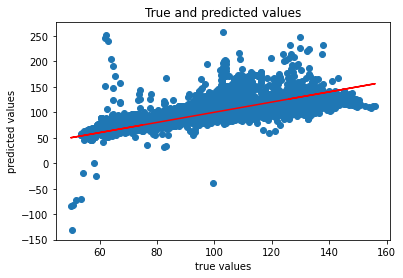

RFE Linear Regression
[-17.3564928  -14.1484839  -11.09362687  -7.74707634  -5.16569546]
R-squared of the model in validation set is: 0.7609399403548651
RMSE: -11.102275074658344


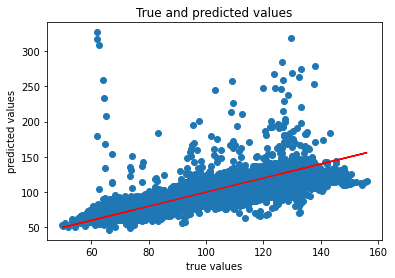

Ridge CV
[-16.88307528 -13.41446147  -9.53331668  -4.4557927  -16.17369445]
R-squared of the model in validation set is: 0.7084715124513341
RMSE: -12.09206811832731


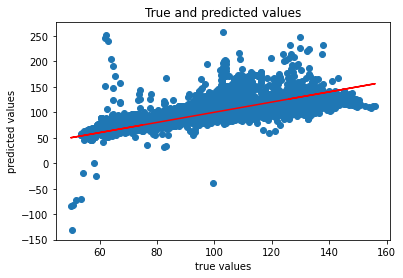

Lasso CV
[-16.88307528 -13.41446147  -9.53331668  -4.4557927  -16.99892383]
R-squared of the model in validation set is: 0.6990451765956105
RMSE: -12.257113994019036


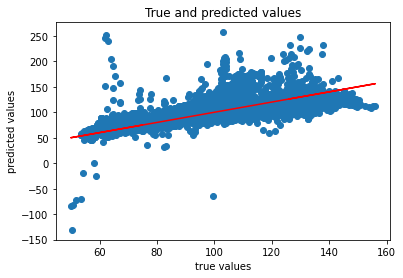

Elastic CV
[-16.88307532 -13.41446147  -9.53331669  -4.45579271 -16.17369447]
R-squared of the model in validation set is: 0.7084715117437445
RMSE: -12.092068131689748


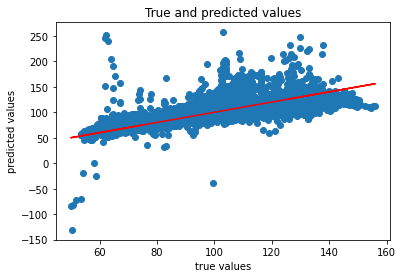

ElasticNetCV(alphas=[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                     0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0,
                     1000000.0, 10000000.0, 100000000.0, 1000000000.0,
                     10000000000.0, 100000000000.0, 1000000000000.0,
                     10000000000000.0, 100000000000000.0, 1000000000000000.0,
                     1e+16, 1e+17, 1e+18, 1e+19, ...],
             copy_X=True, cv=5, eps=0.001, fit_intercept=True, l1_ratio=0.5,
             max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
             positive=False, precompute='auto', random_state=None,
             selection='cyclic', tol=0.0001, verbose=0)

In [0]:
# using original features, X
lin_regCV(X, Y, cv=5)
rfe_reg(X, Y, cv=5)
ridgeCV(X, Y, alphas, cv=5)
lassoCV(X, Y, alphas, cv=5)
elasticCV(X, Y, alphas, cv=5)

The best model is RFE Linear Regression with an RMSE of -11.1 (and R-squared of 0.76).

Linear Regression OLS
[-12.46841772 -10.39890191  -9.10383386  -5.46664817 -12.58598843]
R-squared of the model in validation set is: 0.8137512107162017
RMSE: -10.004758018517455


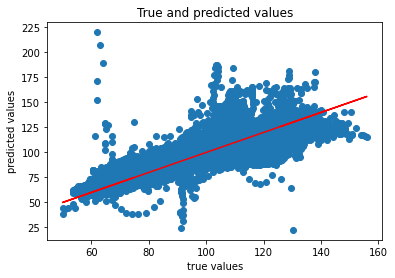

RFE Linear Regression
[-12.29088544 -11.50380515  -9.23539889  -5.53770978  -4.86445905]
R-squared of the model in validation set is: 0.8530844841501843
RMSE: -8.686451660949325


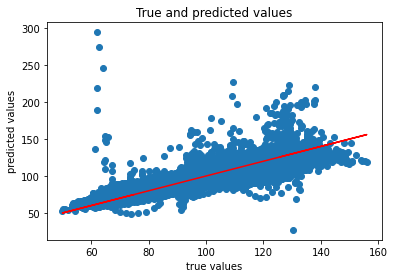

Ridge CV
[-13.44624225 -10.22026639  -9.10383386  -5.46664817 -12.59572813]
R-squared of the model in validation set is: 0.8063195674986111
RMSE: -10.166543759260323


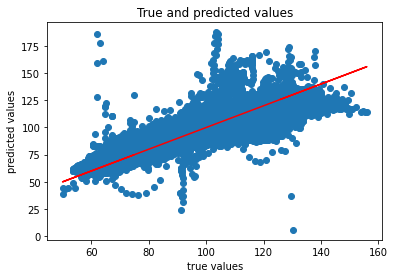

Lasso CV
[-14.15408409 -10.36164959  -9.10162708  -5.46572699 -12.59836452]
R-squared of the model in validation set is: 0.798948610375672
RMSE: -10.336290454878075


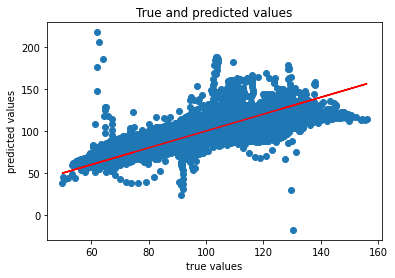

Elastic CV
[-13.51067988 -10.21590499  -9.10162709  -5.43957701 -12.59283587]
R-squared of the model in validation set is: 0.8059473801660321
RMSE: -10.172124968745859


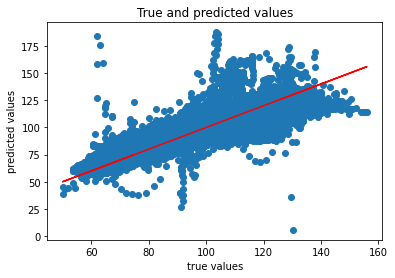

ElasticNetCV(alphas=[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                     0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0,
                     1000000.0, 10000000.0, 100000000.0, 1000000000.0,
                     10000000000.0, 100000000000.0, 1000000000000.0,
                     10000000000000.0, 100000000000000.0, 1000000000000000.0,
                     1e+16, 1e+17, 1e+18, 1e+19, ...],
             copy_X=True, cv=5, eps=0.001, fit_intercept=True, l1_ratio=0.5,
             max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
             positive=False, precompute='auto', random_state=None,
             selection='cyclic', tol=0.0001, verbose=0)

In [0]:
# using augmented features, X_lr
lin_regCV(X_lr, Y, cv=5)
rfe_reg(X_lr, Y, cv=5)
ridgeCV(X_lr, Y, alphas, cv=5)
lassoCV(X_lr, Y, alphas, cv=5)
elasticCV(X_lr, Y, alphas, cv=5)

There seems to be an improvement when X_lr is used instead of X. The best model is RFE Linear Regression with an RMSE of -8.69 (and R-squared of 0.85). We will check the Gauss-Markov assumptions for this model:

In [0]:
lr = LinearRegression()
model = RFE(lr)
model.fit(X_lr, Y)

y_pred = cross_val_predict(model, X_lr, Y, cv=5)

score_rmse = cross_val_score(model, X_lr, Y, cv=5, scoring='neg_root_mean_squared_error')
score_r2 = r2(Y, y_pred)

# Inspect the results.
# print(model.support_)
print('Features sorted by their rank:')
print(sorted(zip(map(lambda x: round(x,2), model.ranking_), X_lr.columns.to_list())))
print('\nCoefficients: \t', model.estimator_.coef_)
print('\nIntercept: \t', model.estimator_.intercept_)

print('RFE Linear Regression')
print(score_rmse)
print("R-squared of the model in validation set is: {}".format(score_r2))
print("RMSE: {}".format(score_rmse.mean()))

Features sorted by their rank:
[(1, 'CAL_gradient'), (1, 'CAL_shift1up'), (1, 'CNC'), (1, 'CNC_gradient'), (1, 'CNC_shift1down'), (1, 'CNC_shift1up'), (1, 'HRD_shift1down'), (1, 'HRD_shift1up'), (1, 'HRM'), (1, 'HRM_gradient'), (1, 'HRM_shift1down'), (1, 'HRM_shift1up'), (1, 'ZDEN_gradient'), (1, 'ZDEN_shift1down'), (1, 'ZDEN_shift1up'), (1, 'logHRD_logCNC_shift1up'), (2, 'CAL'), (3, 'logHRD_logCNC_shift1down'), (4, 'CAL_shift1down'), (5, 'HRD'), (6, 'logHRD_logCNC'), (7, 'PE'), (8, 'PE_gradient'), (9, 'PE_shift1up'), (10, 'PE_shift1down'), (11, 'logHRD_logCNC_gradient'), (12, 'HRD_gradient'), (13, 'GR_shift1up'), (14, 'ZDEN'), (15, 'GR'), (16, 'GR_shift1down'), (17, 'GR_gradient')]

Coefficients: 	 [ 47.26766353   4.84740019  -6.69316448 -17.10533817  15.99326274
 -30.14532465   0.47422395  12.34208105   3.61959063  26.20499483
  -7.33685929   2.02437219  -1.17326634  37.46051963 -33.35768649
  -8.81325937]

Intercept: 	 121.1788635420931
RFE Linear Regression
[-12.29088544 -11.503805

Assumption two: the error term should be zero on average

In [0]:
predictions = model.predict(X_lr)
errors = Y - y_pred

print("Mean of the errors in the model is: {}".format(np.mean(errors)))

Mean of the errors in the model is: 0.5178795261240213


Assumption three: homoscedasticity

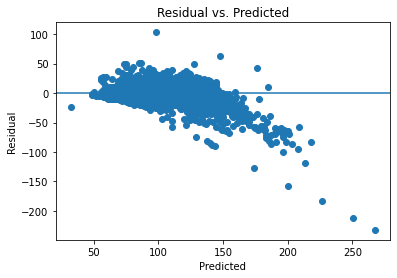

In [0]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [0]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 18155.8 and p value is 0
Levene test statistic value is 15806 and p value is 0


The p-values of both tests are lower than 0.05. So, the test results reject the null hypothesis which means our errors are heteroscedastic.

Assumption four: low multicollinearity. Based on the pairplot and correlation tests run previously, this assumption has been violated.

Assumption five: error terms should be uncorrelated with one another

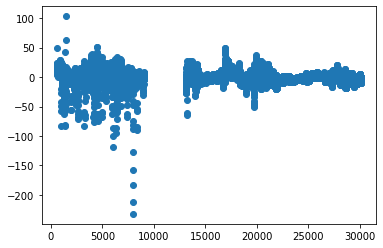

In [0]:
plt.plot(errors, 'o')
plt.show()

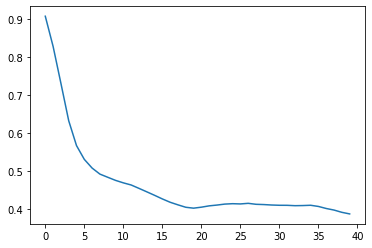

In [0]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

Assumption six: Exogeneity (features should not be correlated with the errors)

In [0]:
df_exog = pd.concat([X_lr, pd.DataFrame(errors.values, columns=["error"])], axis=1)
df_exog.corr().iloc[:,-1:]

,error
CAL_shift1down,0.092276
CNC_shift1down,0.070651
GR_shift1down,0.302464
HRD_shift1down,-0.003787
HRM_shift1down,-0.003013
PE_shift1down,0.122810
ZDEN_shift1down,-0.061167
logHRD_logCNC_shift1down,0.049776
CAL,0.100456
CNC,0.069503


Some features (such as GR) are correlated with the errors.

We find many Gauss-Markov assumptions have been violated, hence making the linear prediction models unstable. We will therefore proceed with building non-parametric models.

# Building Non-Parametric Models

## KNN

In [0]:
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [0]:
#---# Applying Grid Search to find the best model and the best parameters
from sklearn.model_selection import GridSearchCV

model = neighbors.KNeighborsRegressor()

parameters = [{'n_neighbors': [1,2,4,5,6,8,10,15,20,30,40,50,75,100,125,150,175,200,300,400,500,750,1000], 'weights': ['distance', 'uniform']}]

grid_search_knn = GridSearchCV(estimator = model, param_grid = parameters,scoring = 'neg_root_mean_squared_error', cv = 5, n_jobs = -1)

grid_search_knn = grid_search_knn.fit(X, Y)

accuracy_knn = grid_search_knn.best_score_

print(accuracy_knn)
print(grid_search_knn.best_params_)

-15.316916669905677
{'n_neighbors': 4, 'weights': 'distance'}


[-18.20811027 -14.92607603 -19.29560382  -9.25181823 -14.7640643 ]
KNN RMSE: -15.29 (+/- 7.01)
KNN R2: 0.58


Text(0, 0.5, 'DTC Predicted')

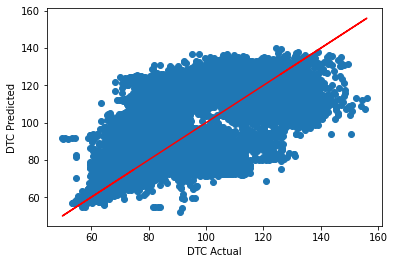

In [0]:
# using optimal hyperparameter
knn = neighbors.KNeighborsRegressor(n_neighbors=4, weights='distance')
knn.fit(X, Y)

score_DT = cross_val_score(knn, X, Y, cv=5, scoring = 'neg_root_mean_squared_error')
print(score_DT)
print("KNN RMSE: %0.2f (+/- %0.2f)" % (score_DT.mean(), score_DT.std() * 2))

y_pred = cross_val_predict(knn, X, Y, cv=5)
score_DT_r2 = r2(Y, y_pred)
print("KNN R2: %0.2f" % (score_DT_r2.mean()))

plt.scatter(Y, y_pred)
plt.plot(Y, Y, color="red")
plt.xlabel('DTC Actual')
plt.ylabel('DTC Predicted')

[-17.59428613 -13.87351551 -17.86650472 -13.41524339 -17.2827199 ]
KNN RMSE: -16.01 (+/- 3.89)
KNN R2: 0.58


Text(0, 0.5, 'DTC Predicted')

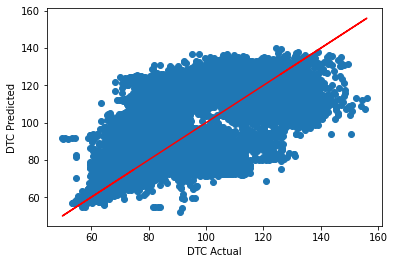

In [0]:
# using optimal hyperparameter
knn = neighbors.KNeighborsRegressor(n_neighbors=4, weights='distance')
knn.fit(X_lr, Y)

score_DT = cross_val_score(knn, X_lr, Y, cv=5, scoring = 'neg_root_mean_squared_error')
print(score_DT)
print("KNN RMSE: %0.2f (+/- %0.2f)" % (score_DT.mean(), score_DT.std() * 2))

y_pred = cross_val_predict(knn, X, Y, cv=5)
score_DT_r2 = r2(Y, y_pred)
print("KNN R2: %0.2f" % (score_DT_r2.mean()))

plt.scatter(Y, y_pred)
plt.plot(Y, Y, color="red")
plt.xlabel('DTC Actual')
plt.ylabel('DTC Predicted')

## Random Forest

In [0]:
#---# Applying Grid Search to find the best model and the best parameters
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble

model = ensemble.RandomForestRegressor(criterion = 'mse',
                                       n_jobs = -1)

parameters = [{'max_features': [1,2,3,4,5,6,7],
               'min_samples_split': [10,20,30,40,50,60,70,80,90,100,150,200, 250, 260, 280, 300],#500],
               'n_estimators' : [100, 200, 250]#, 500, 750, 1000]# 1250, 1500, 1750, 2000, 3000, 5000]
               }]

grid_search_rf = GridSearchCV(estimator = model,
                              param_grid = parameters,
                              scoring = 'neg_root_mean_squared_error',
                              cv = 5,
                              n_jobs = -1)

grid_search_rf = grid_search_rf.fit(X, Y)

accuracy_rf = grid_search_rf.best_score_

print(accuracy_rf)
print(grid_search_rf.best_params_)

-9.078551943957772
{'max_features': 5, 'min_samples_split': 280, 'n_estimators': 100}


In [0]:
#---# Applying Grid Search to find the best model and the best parameters
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble

model = ensemble.RandomForestRegressor(criterion = 'mse',
                                       n_jobs = -1)

parameters = [{'max_features': ['sqrt', 'log2', 3,4,5,6,7],
               'min_samples_split': [30,40,50,60,70,80,90,100,150,200, 250, 260, 280]#10,20, 300],#500], ### try [10,50,100]
               'n_estimators' : [100, 200]#, 250]#, 500, 750, 1000]# 1250, 1500, 1750, 2000, 3000, 5000]
               }]

grid_search_rf = GridSearchCV(estimator = model,
                              param_grid = parameters,
                              scoring = 'neg_root_mean_squared_error',
                              cv = 5,
                              n_jobs = -1)

grid_search_rf = grid_search_rf.fit(X_lr, Y)

accuracy_rf = grid_search_rf.best_score_

print(accuracy_rf)
print(grid_search_rf.best_params_)

[-16.75692128 -11.28127958  -7.46087879  -4.51109545  -7.15891386]
Random Forest RMSE: -9.43 (+/- 8.50)
Random Forest R2: 0.84


Text(0, 0.5, 'DTC Predicted')

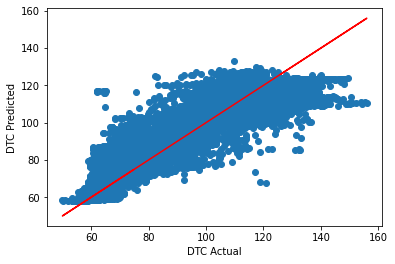

In [0]:
# using optimal hyperparameter & original features
rf = ensemble.RandomForestRegressor(criterion = 'mse',
                                     max_features = 5, 
                                     min_samples_split = 280, 
                                     n_estimators = 100,
                                     n_jobs = -1)
rf.fit(X, Y)

score_DT = cross_val_score(rf, X, Y, cv=5, scoring = 'neg_root_mean_squared_error')
print(score_DT)
print("Random Forest RMSE: %0.2f (+/- %0.2f)" % (score_DT.mean(), score_DT.std() * 2))

y_pred = cross_val_predict(rf, X, Y, cv=5)
score_DT_r2 = r2(Y, y_pred)
print("Random Forest R2: %0.2f" % (score_DT_r2.mean()))

plt.scatter(Y, y_pred)
plt.plot(Y, Y, color="red")
plt.xlabel('DTC Actual')
plt.ylabel('DTC Predicted')

[-16.1002877   -9.23334262  -6.12362561  -4.06440929  -7.31985769]
Random Forest RMSE: -8.57 (+/- 8.25)
Random Forest R2: 0.86


Text(0, 0.5, 'DTC Predicted')

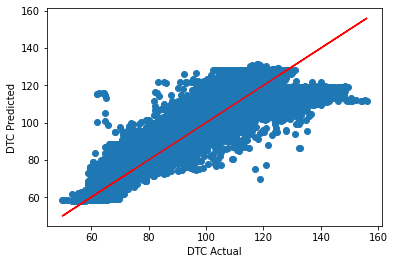

In [0]:
# using optimal hyperparameter & augmented features
rf = ensemble.RandomForestRegressor(criterion = 'mse',
                                     max_features = 14, 
                                     min_samples_split = 280, 
                                     n_estimators = 100,
                                     n_jobs = -1)
rf.fit(X_lr, Y)

score_DT = cross_val_score(rf, X_lr, Y, cv=5, scoring = 'neg_root_mean_squared_error')
print(score_DT)
print("Random Forest RMSE: %0.2f (+/- %0.2f)" % (score_DT.mean(), score_DT.std() * 2))

y_pred = cross_val_predict(rf, X_lr, Y, cv=5)
score_DT_r2 = r2(Y, y_pred)
print("Random Forest R2: %0.2f" % (score_DT_r2.mean()))

plt.scatter(Y, y_pred)
plt.plot(Y, Y, color="red")
plt.xlabel('DTC Actual')
plt.ylabel('DTC Predicted')

## SVR

In [0]:
# Applying Grid Search to find the best model and the best parameters
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

model = SVR(max_iter=-1)

parameters = [{'C': [1, 10, 100, 1000],
               'kernel': ['rbf'],
               'gamma': ['auto', 'scale', 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 10, 100]}]

grid_search_SVR = GridSearchCV(estimator = model,
                               param_grid = parameters,
                               scoring = 'neg_root_mean_squared_error',
                               cv = 5,
                               n_jobs = -1)

grid_search_SVR = grid_search_SVR.fit(X, Y)

accuracy_SVR = grid_search_SVR.best_score_

print(accuracy_SVR)
print(grid_search_SVR.best_params_)

[-21.59006345 -13.57328966 -15.15235287 -22.45165437 -11.89300483]
Support Vector RMSE: -16.93 (+/- 8.58)
Support Vector R2: 0.48


Text(0, 0.5, 'DTC Predicted')

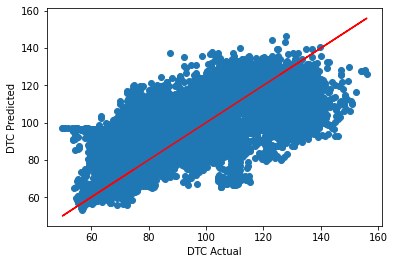

In [0]:
# using optimal hyperparameter & original features
svr = SVR(C = 100,
          gamma = 0.1,
          kernel = 'rbf',
          max_iter = -1)

svr.fit(X, Y)

score_DT = cross_val_score(svr, X, Y, cv=5, scoring = 'neg_root_mean_squared_error')
print(score_DT)
print("Support Vector RMSE: %0.2f (+/- %0.2f)" % (score_DT.mean(), score_DT.std() * 2))

y_pred = cross_val_predict(svr, X, Y, cv=5)
score_DT_r2 = r2(Y, y_pred)
print("Support Vector R2: %0.2f" % (score_DT_r2.mean()))

plt.scatter(Y, y_pred)
plt.plot(Y, Y, color="red")
plt.xlabel('DTC Actual')
plt.ylabel('DTC Predicted')

[-32.17475307 -17.70612412 -20.22124564 -29.99235118 -20.79474027]
Support Vector RMSE: -24.18 (+/- 11.55)
Support Vector R2: 0.06


Text(0, 0.5, 'DTC Predicted')

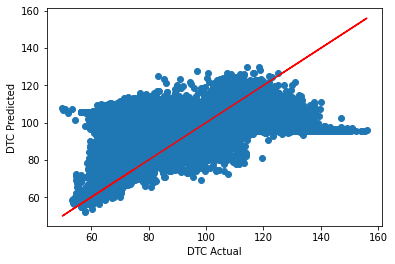

In [0]:
# using optimal hyperparameter
svr = SVR(C = 100,
          gamma = 0.1,
          kernel = 'rbf',
          max_iter = -1)

svr.fit(X_lr, Y)

score_DT = cross_val_score(svr, X_lr, Y, cv=5, scoring = 'neg_root_mean_squared_error')
print(score_DT)
print("Support Vector RMSE: %0.2f (+/- %0.2f)" % (score_DT.mean(), score_DT.std() * 2))

y_pred = cross_val_predict(svr, X_lr, Y, cv=5)
score_DT_r2 = r2(Y, y_pred)
print("Support Vector R2: %0.2f" % (score_DT_r2.mean()))

plt.scatter(Y, y_pred)
plt.plot(Y, Y, color="red")
plt.xlabel('DTC Actual')
plt.ylabel('DTC Predicted')

## Taking the log of the target variable
Best scores from different models:
* KNN RMSE: -15.29 (+/- 7.01), 0.58
* RF RMSE: -8.57 (+/- 8.25), 0.86
* SVR RMSE: -16.93 (+/- 8.58), 0.48

In [0]:
from sklearn.model_selection import KFold

def cv_score_logy_on_original_scale(model, X, y, cv = 5):
    kf = KFold(n_splits = cv, random_state=None, shuffle=False) # Define the split - into 5 folds
    ylog = np.log10(y)
    
    score_DT = []
    score_DT_r2 = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        ylog_train, ylog_test = ylog.iloc[train_index], ylog.iloc[test_index]
        
        model.fit(X_train, ylog_train)
        
        ylog_pred = model.predict(X_test)
        y_pred = np.power(10,ylog_pred)
        
        cv_n_score = rmse(y_test, y_pred)
        score_DT.append(cv_n_score)

        score_DT_r2.append(r2(y_test, y_pred))

    print(score_DT)
    print("RMSE: %0.2f (+/- %0.2f)" % (np.mean(score_DT), np.std(score_DT) * 2))
    print("R2: %0.2f" % np.mean(score_DT_r2))

    plt.scatter(y_test, y_pred)
    plt.plot(y_test, y_test, color="red")
    plt.xlabel('DTC Actual')
    plt.ylabel('DTC Predicted')

## KNN

[-18.349117220615234, -14.893121716217262, -19.21251414485626, -9.270125016620318, -14.577487560852413]
RMSE: -15.26 (+/- 7.02)
R2: 0.42


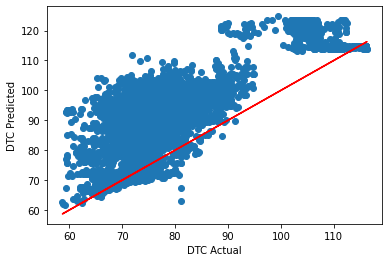

In [0]:
# using optimal hyperparameter
knn = neighbors.KNeighborsRegressor(n_neighbors=4, weights='distance')
knn.fit(X, Y_log)

cv_score_logy_on_original_scale(knn, X, Y, cv = 5)

[-17.700926332635177, -13.873121982408858, -17.790755963537652, -13.418346105558967, -17.13057100166361]
RMSE: -15.98 (+/- 3.85)
R2: 0.32


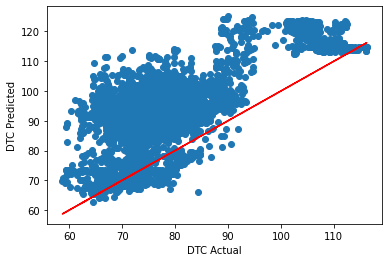

In [0]:
# using optimal hyperparameter
knn = neighbors.KNeighborsRegressor(n_neighbors=4, weights='distance')

cv_score_logy_on_original_scale(knn, X_lr, Y, cv = 5)

## Random Forest

[-16.907501287671398, -9.722503642722709, -7.132805699514062, -4.308408689264102, -6.744049998777189]
RMSE: -8.96 (+/- 8.65)
R2: 0.71


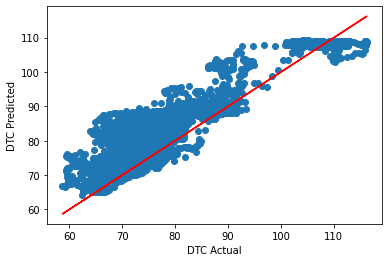

In [0]:
# using optimal hyperparameter
rf = ensemble.RandomForestRegressor(criterion = 'mse',
                                     max_features = 5, 
                                     min_samples_split = 280, 
                                     n_estimators = 100,
                                     n_jobs = -1)

rf.fit(X, Y_log)

cv_score_logy_on_original_scale(rf, X, Y, cv = 5)

[-16.914782952023394, -9.294018340612899, -5.7706068802383195, -3.925266740059462, -7.2727635657698135]
RMSE: -8.64 (+/- 9.00)
R2: 0.73


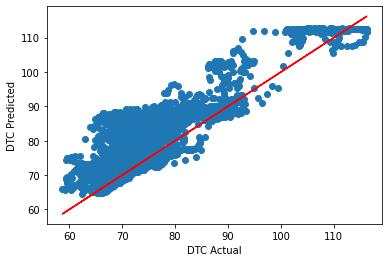

In [0]:
# using optimal hyperparameter
rf = ensemble.RandomForestRegressor(criterion = 'mse',
                                     max_features = 14, 
                                     min_samples_split = 280, 
                                     n_estimators = 100,
                                     n_jobs = -1)

rf.fit(X_lr, Y_log)

cv_score_logy_on_original_scale(rf, X_lr, Y, cv = 5)

## SVR

[-36.15873454913172, -13.544388021145071, -13.760867911497193, -20.62719429262134, -15.409115871380488]
RMSE: -19.90 (+/- 17.04)
R2: 0.25


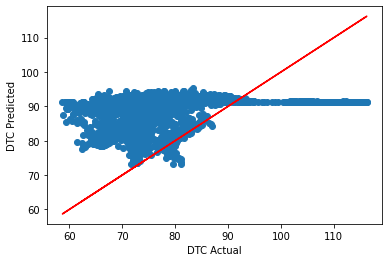

In [0]:
svr = SVR(C = 100,
          gamma = 0.1,
          kernel = 'rbf',
          max_iter = -1)

svr.fit(X, Y_log)

cv_score_logy_on_original_scale(svr, X, Y, cv = 5)

[-38.30254730750474, -17.397028978614223, -17.553447621808125, -26.803177039590626, -21.479696174189414]
RMSE: -24.31 (+/- 15.58)
R2: 0.17


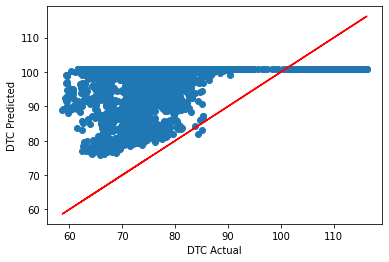

In [0]:
svr = SVR(C = 100,
          gamma = 0.1,
          kernel = 'rbf',
          max_iter = -1)

svr.fit(X_lr, Y_log)

cv_score_logy_on_original_scale(svr, X_lr, Y, cv = 5)

Predicting on the log of the target variable does not seem to have a significant impact on improving the scores of the model.

# Conclusion

* Linear models are not suitable for predicting the target variable DTC since many of the Gauss-Markov assumptions are violated.

* The augmented features X_lr using value shifts, gradient calculation (Bestagini et al, 2017), and Archie's relationship (Chen and Zeng, 2018) result in an improvement in prediction scores as measured by RMSE and R-squared values.

* Based on all the different models attempted, the best model for predicting DTC (Y) is:
```
rf = ensemble.RandomForestRegressor(criterion = 'mse',
                                     max_features = 14, 
                                     min_samples_split = 280, 
                                     n_estimators = 100,
                                     n_jobs = -1)
```

using the augmented features, X_lr, resulting in an RMSE of -8.57 (+/- 8.25) and R-squared of 0.86.